In [1]:
import pandas as pd
import scanpy as sc
import glob
import numpy as np
import seaborn as sns; 
import matplotlib.pyplot as plt
import scipy as sp

<div class="alert alert-info">

**Note**
    
This notebook provides analysis on the critical gene analysis. 
    
</div>  

# Define parameters

In [2]:
# Different dataset have diffrerent column name to store the celltype
def get_ct(data): 
    if(data=="GSE110894"):
        return("Sample name")
    elif(data=="GSE117872_HN120"):
        return("cell_color")
    elif(data=="GSE117872_HN137"):
        return("cell_color")
    else:
        return("sensitivity")

In [5]:
# Select DATA case as GSE117872
# The critical gene will be orderd by log fold change
DATA = "GSE117872_HN137"
PCT_EXP = 25
ORDER = 'log_fc'
sc.settings.set_figure_params(dpi=100, facecolor='white')

# Read critical gene names

The input of this step is a txt matrix file of the Captum calculated integrated gradients. Will be generated if we applied --printgene 'T' in the scmodel.py script. "sc_gradient.txt"

In [6]:
# Change it to your path that save h5ad for HN120 critical gene gradient
f_cg = glob.glob("C:/Users/Varun/Desktop/LiU_STIMA/Semester_3/Research_Project/scDEAL/save/"+DATA+"sc_gradient.txt")
df_cg = pd.read_csv(f_cg[0],sep=" ",header=None)

In [7]:
# Change it to your path that save h5ad for HN120 critical gene name
f_gn = glob.glob("C:/Users/Varun/Desktop/LiU_STIMA/Semester_3/Research_Project/scDEAL/save/"+DATA+"sc_gene.csv")
df_gene = pd.read_csv(f_gn[0],index_col=0)

In [8]:
df_cg.columns = df_gene.iloc[:,0].values

# Read result h5ad files

In [13]:
adata_fname

['C:/Users/Varun/Desktop/LiU_STIMA/Semester_3/Research_Project/scDEAL/save/adata\\GSE117872_HN137integrate_data_GSE117872_HN137_drug_CISPLATIN_bottle_256_edim_512,256_pdim_256,128_model_VAE_dropout_0.3_gene_T_lr_0.01_mod_new_sam_upsampling.h5ad']

In [12]:
# Change it to your path that saved h5ad for the case study
adata_fname = glob.glob("C:/Users/Varun/Desktop/LiU_STIMA/Semester_3/Research_Project/scDEAL/save/adata/"+DATA+"*h5ad")

In [14]:
adata = sc.read_h5ad(adata_fname[0])

The metadata feil is shown as follows

In [15]:
adata.obs.head()

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,sensitivity,...,pct_counts_rps,total_counts_rpl,pct_counts_rpl,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds
RHH1479,HN137P,red,HN137,Primary,Sensitive,2,2,3,1,Sensitive,...,6.244340,108732.402388,10.874201,3,3,0.004184,0,0.944636,1,0.053163
RHH1480,HN137P,red,HN137,Primary,Sensitive,2,2,3,1,Sensitive,...,7.923420,131578.213349,13.157948,3,3,0.001399,0,0.556644,1,0.459443
RHH1481,HN137P,red,HN137,Primary,Sensitive,2,2,3,1,Sensitive,...,6.746207,121841.261626,12.184268,3,3,0.080895,0,0.914518,1,0.086539
RHH1482,HN137P,red,HN137,Primary,Sensitive,2,2,3,1,Sensitive,...,8.061604,133835.926421,13.384471,3,3,0.001070,0,0.956246,1,0.041052
RHH1483,HN137P,red,HN137,Primary,Sensitive,4,2,2,1,Sensitive,...,5.900666,69861.970909,6.988271,2,2,1.000000,1,0.757593,1,0.204122


# Read result h5ad files

We organize different comparison groups stored in a map. Each group are selected subsets of the dataset. We will compare one versus rest comparisons with each other

5

In [36]:
map_ref_group = {
    1: ["HN137P",'HN137PCR'],
    2: ['HN137P',"HN137M"],
    3: ['HN137PCR','HN137MCR'],
    4: ['HN137P','HN137PCRDH','HN137PCR'],
    5: ['HN137M','HN137MCRDH','HN137MCR'],
}

In [37]:
df_cg.index = adata.obs.index

Propsessing the critical gene matrix

In [38]:
df_cg = abs(df_cg)
igadata= sc.AnnData(df_cg)
igadata.var.index = adata.var.index
igadata.obs.index = adata.obs.index
igadata.obs=adata.obs
igadata.obs['sens_label'] = adata.obs['sens_label'].astype('category')

In [39]:
sc.pp.filter_cells(igadata, min_genes=200)
sc.pp.filter_genes(igadata, min_cells=3)
#sc.pl.highest_expr_genes(igadata, n_top=20, )
sc.pp.normalize_total(igadata)
sc.pp.log1p(igadata)
sc.pp.highly_variable_genes(igadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
igadata.obs['sens_label'] = adata.obs['sens_label'].astype('category')
rg_result = sc.tl.rank_genes_groups(igadata, 'sens_label',method='wilcoxon',pts=True)

Preview meta of the integrated gradient matrix

In [40]:
igadata.obs.cell_color.values

['HN137P', 'HN137P', 'HN137P', 'HN137P', 'HN137P', ..., 'HN137PCRDH', 'HN137PCRDH', 'HN137PCRDH', 'HN137PCRDH', 'HN137PCRDH']
Length: 568
Categories (5, object): ['HN137M', 'HN137MCR', 'HN137P', 'HN137PCR', 'HN137PCRDH']

# Perform wilcoxon tests on integrated gradient values among clusters

In [41]:
map_ref_group[1]

['HN137P', 'HN137PCR']

c:\Users\Varun\anaconda3\envs\scDEAL\lib\site-packages\scanpy\tools\_rank_genes_groups.py:574: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


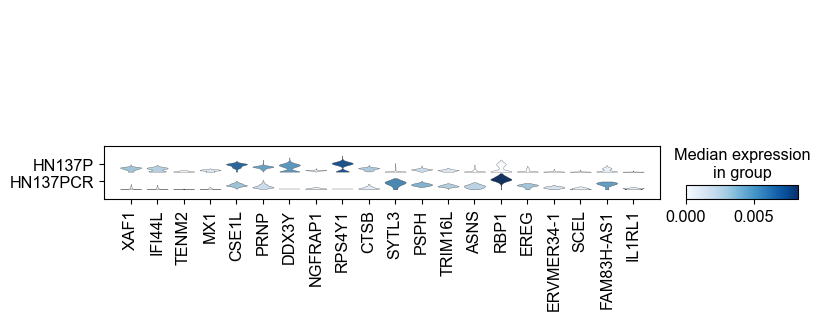

c:\Users\Varun\anaconda3\envs\scDEAL\lib\site-packages\scanpy\tools\_rank_genes_groups.py:574: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


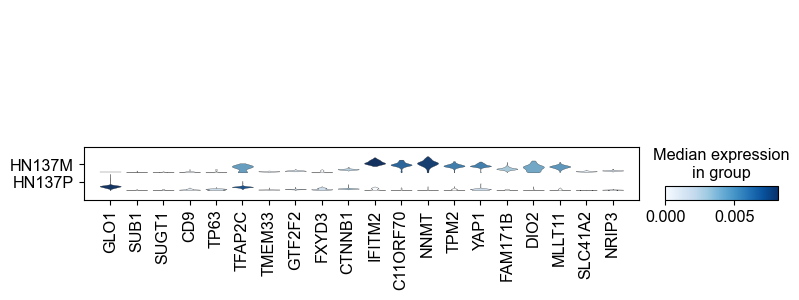

c:\Users\Varun\anaconda3\envs\scDEAL\lib\site-packages\scanpy\tools\_rank_genes_groups.py:574: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


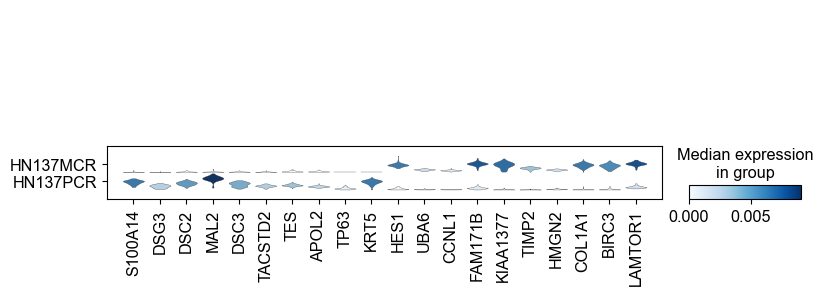

c:\Users\Varun\anaconda3\envs\scDEAL\lib\site-packages\scanpy\tools\_rank_genes_groups.py:574: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


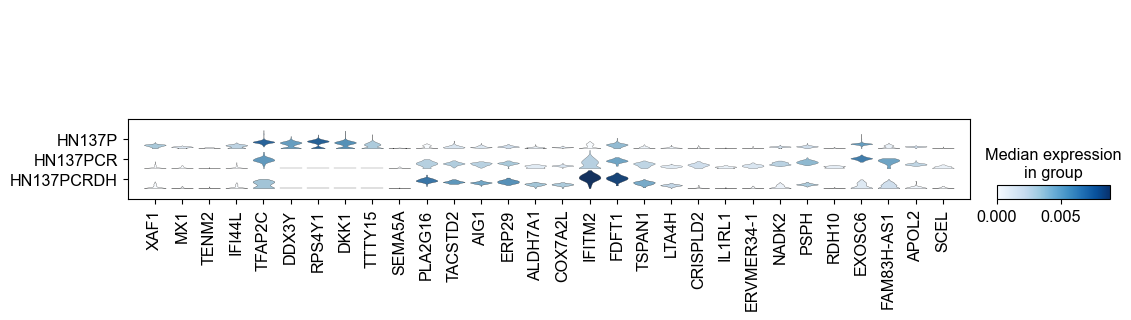

c:\Users\Varun\anaconda3\envs\scDEAL\lib\site-packages\scanpy\tools\_rank_genes_groups.py:574: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


IndexError: index 0 is out of bounds for axis 0 with size 0

In [43]:
# Save the gene tables into csv files
for i in range(1,6):
    subset_igdata = igadata[igadata.obs['cell_color'].isin(map_ref_group[i])]
    rg_result = sc.tl.rank_genes_groups(subset_igdata, 'cell_color', groups=map_ref_group[i], reference='rest', method='wilcoxon',pts =True)
    #sc.pl.rank_genes_groups(subset_igdata, groups=map_ref_group[i], n_genes=20,save="critical_genes_rank_"+str(clip)+str(i)+".svg")
    df_name = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['names'])#.to_csv("critical_genes_experiment_"+str(i)+".csv")
    df_lgfc = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['logfoldchanges'])#.to_csv("critical_logfc_experiment_"+str(i)+".csv")
    df_pval = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['pvals_adj'])#.to_csv("critical_genes_experiment_"+str(i)+".csv")
    df_pts = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['pts'])#.to_csv("critical_logfc_experiment_"+str(i)+".csv")

    for c in df_name.columns:
        tmp_df = pd.DataFrame({"gene_name":df_name[c],"log_fc":df_lgfc[c],'pvals_adj':df_pval[c],'pts':df_pts.loc[df_name[c].values,c].values})
        tmp_df.to_csv("critical_genes_experiment_"+str(i)+"_type_"+str(c)+"_vs_others.csv")

    sc.pl.stacked_violin(subset_igdata, pd.DataFrame(subset_igdata.uns['rank_genes_groups']['names']).head(10).T.values.ravel(), groupby='cell_color',\
                        rotation=180,save="critical_genes_violint_"+str(i)+".svg"
                        );

# Filter critical gens by logfc val and percentages

In [44]:
gene = pd.read_csv("critical_genes_experiment_1_type_HN120P_vs_others.csv")
gene = gene[gene['log_fc'].abs()>0.1]
gene = gene[gene['pvals_adj']<=0.05]
gene = gene[gene['pts']>0.2]
gene=gene.sort_values("log_fc",ascending=True)
res = list(gene[gene['log_fc']<0]['gene_name'])
gene=gene.sort_values("log_fc",ascending=False)
sen=list(gene[gene['log_fc']>0]['gene_name'])

FileNotFoundError: [Errno 2] No such file or directory: 'critical_genes_experiment_1_type_HN120P_vs_others.csv'

Print head sensitive critical genes and resistant genes

In [ ]:
print(res[:10])

In [ ]:
print(sen[:10])